The finding of adequate hyper parameters is crucial to improve the performance and generalization of machine learning models. There are several methods described in modern literature that can help to find the best fitting hyper parameters. The performance is tested in different dataset that are tested and well studied, such as MINST. Hyper parameters (HP) are external to the learning process but significantly impact model performance. HP are external to the learning process but significantly impact model performance. Effective tuning typically requires domain expertise or computationally expensive methods like brute-force search.
Effective tuning typically requires domain expertise or computationally expensive methods like brute-force search In [1, 2, 3], the Bayesian optimization is explored.  Bayesian optimization leverages prior knowledge to update posterior distributions based on sample data, guiding the search for optimal hyperparameter configurations efficiently. Traditional approaches like grid search and random search are computationally expensive and less effective in high-dimensional spaces. Bayesian optimization offers a more efficient alternative, particularly for expensive, black-box objective functions. 
In [1] the use of Bayesian optimization is explored for tuning hyper parameters in machine learning models, which is critical for improving model performance. The study proposes a method using Bayesian optimization with Gaussian processes. Traditional approaches like grid search and random search are computationally expensive and less effective in high-dimensional spaces. Bayesian optimization offers a more efficient alternative, particularly for expensive, black-box objective functions. The results were conducted on machine learning models like random forests, neural networks (CNN and RNN), and deep forests (gcForest). Bayesian optimization demonstrated significant improvements in prediction accuracy and computational efficiency compared to traditional methods.The results confirm that Bayesian optimization outperforms other optimization techniques in terms of speed and achieving better model performance, especially in scenarios with limited computational resources or high-dimensional hyperparameter spaces.

In [2] it is stated that complex models like Deep Belief Networks (DBNs) have numerous hyper parameters, making manual optimization inefficient and inconsistent.
The difficulty in tuning these models hinders reproducibility and progress in machine learning research. Therefore, the proposed approaches is based on
Random Search, a method where hyper parameters are sampled randomly from predefined distributions. It is efficient for simple problems but struggles with complex models like DBNs. In order to improve this disadvantage, the Sequential Model-Based Optimization is introduced.
This method approximates the loss function with a surrogate model to guide the search. Two specific variants of the methods are explained: Gaussian Process and the
Tree-Structured Parzen Estimator. Both methods were tested on DBNs with up to 32 hyper parameters across tasks like image classification on datasets such as MNIST and MRBI. The results show, that Random search matched human manual optimization for simple tasks but failed for harder datasets.
Tree-Structured Parzen Estimator consistently outperformed both random search and manual tuning, achieving better accuracy and efficiency.The Gaussian Process was effective but less efficient than TPE due to computational overhead.

In [3], the results proves that experiments were conducted on machine learning models like random forests, neural networks (CNN and RNN), and deep forests (gcForest). Bayesian optimization demonstrated significant improvements in prediction accuracy and computational efficiency compared to traditional methods.
The results confirm that Bayesian optimization outperforms other optimization techniques in terms of speed and achieving better model performance, especially in scenarios with limited computational resources or high-dimensional hyperparameter spaces.





[1] Hyunghun Cho et al.: *Basic Enhancement Strategies When Using Bayesian Optimization for Hyperparameter Tuning of Deep Neural Networks*, Special section on scalable deeo learning for big data, VOLUME 8, Digital Object Identifier 10.1109/ACCESS.2020.2981072, pp. 52588-52608 IEEE Access, 2020

[2] James Bergstra et al: *Algorithms for Hyper-Parameter Optimization*, NIPS'11: Proceedings of the 24th International Conference on Neural Information Processing Systems,  pp. 2546 - 2554, 2011

[3] Jia Wu et al: *Hyperparameter Optimization for Machine Learning Models Based on Bayesian Optimization*, Journal of Electronic Science , VOL. 17, NO. 1,Digital Object Identifier:10.11989/JEST.1674-862X.80904120, pp.26 - 40, 2019, 

## Preparation of data and environment and Import MINST dataset 
In this example, the MINST data set is used to apply the Bayesian Optimization for the hyper parameters of a neuronal network NN.\
The library *tensorflow* is used to define the NN. *Tensorflow* contains the data set MNIST which contains a grau scaled hand written numbers 0 to 9. All images are taged and therefore a supervised train strategy can be applied.\
Addtionally, the library *GPyOpt* is imported to optimize the hyper parameters using the *Gaussian Process*. GPyOpt is a Python library for Bayesian Optimization using Gaussian Processes (GPs). It is designed to help with optimizing expensive-to-evaluate functions, especially those that are non-convex, noisy, or black-box (where the internal function mechanism is unknown). The library leverages GPs to model the objective function and provides efficient methods to explore the search space.

### Possible Applications
A trained model can be used to detect hand writing and convert it into standard block writing. The data set must be expanded to hand written letters and mybe special characters, but a neuronal network like the one used in this project should easily manage this. Another application - also cnsidering the exantion of letters - is the detection of car plates in traffic routs to identify cars above the speed limits.  

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## necessary libraries to build model tensorflow (objective funciton)
import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import GPyOpt


## Load and prepare the dataset
The data set needs to be loaded. The data set contains 70000 pictures of hand written numbers form 0 to 9. Each picture is a matrix of 28 x 28 pixels. Each pixel can obtain a value between 0 (correspondng to color black) and 255 (correspondng to color white). Therefore, the input data ara normalized by dividing by 255. The output signal is contain the corresponding number form 0 to 9. The data set is deivided into 60000 pictures to train the model and 10000 pictures to validate the model. 

In [4]:
# Load MNIST dataset
# Split into training and testing datasets
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_train.shape

(60000, 28, 28)

Since the output is a categoial variable the the method One-Shot- is applied with ten cathegories or classes, each for every number between 0 and 9. The numerical numbers have to be cathgorized. 

In [5]:
np.random.seed(42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 10)

The following figure illustrates the data: the X values are matrices of 28 x 28 pixels with a hand written number, the corresponding Y values contain the number.

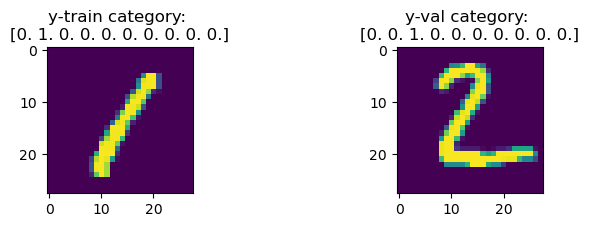

In [6]:
import matplotlib.pyplot as plt
m = X_train.shape
plt.subplot(1,3,1)
plt.imshow(X_train[3])
plt.title("y-train category: \n" + str(y_train[3]))
plt.subplot(1,3,3)
plt.imshow(X_val[1])
plt.title("y-val category: \n" + str(y_val[1]))
plt.show()

## Model Description (Objective Function)
The picture below shows a possible structure of a neuronal network (NN). The network has an input layer. In case of the MNIST set, the inputs are the picture 28 x 28. The NN is not able to recieve input in a matrix format. Therefore, the matrix is converted to a vector with 784 (28 x 28) elements. All inputs are send to the first hidden layer which contains a number of neurons.The output of these neurons are the inputs the second layer with a defined number of neurons. The number of neurons of both layers is not necessarily equal. The the las layer is called the output layer and must have 10 neurones, one for each possible number. Each input is connected to each neuron of the following layer. The inputs are multiplied with a weight $w$ and the sum of all weighted input is calculated as output of the neuron.
$$
y_{jk} = \sum_{i=1}^N {w_i x_i}
$$
with j the layer number and k the number of the neuron in layer j
The activation function in each hidden layer is Rectified Linear Unit (relu) a linear function for values higher than or equal to 0 and 0 for negative values. During the train phase, the NN is trained to identify the correct interpretation of the picture. To do so, the red optimizes the weights $w_{ik}$ applying a method called Backpropagation.\
### Backpropagation
The input data flows through the network layer by layer, applying weights and biases, and activating functions until the output is generated. Then, the loss function compares the network's predicted output with the actual target (e.g., Mean Squared Error for regression). Then, the the gradient of the loss is   calculate with respect to the weights and biases in the output layer using the chain rule of calculus. This is the derivative of the loss function with respect to the activations of the last layer. The gradients are propagated backward from the output to the input layers using the chain rule. For each neuron, it is computed how much it contributed to the error in the next layer. Then,  each weight $w$and bias $b$ using a rule like Gradient Descent:
$$ 
w = w − η ⋅  \frac{∂w}{∂L} 

$$


​
$$ 
𝑏 = 𝑏 −𝜂⋅\frac{∂𝐿}{∂𝑏} 
$$
- η is the learning rate
- $\frac{∂w}{∂L}$ the gradient of loss with respect to weight $w$.\
This process is repeated over the number of epochs until the loss function improves significantly.

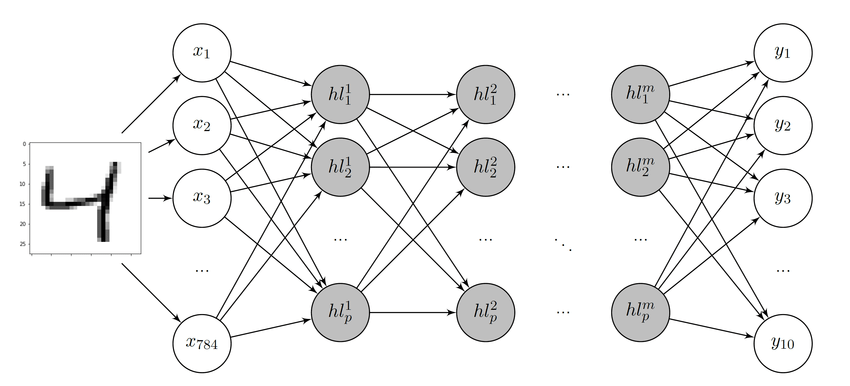

In oder to run the optimization, it is necessary to implement the creation of ne NN structure in a way that the parameters of interest can be varied automatically. The parameter of interest are the following: 
-   *learning rate*: Controls how much to adjust the model's weights with respect to the loss gradient, typically 1e-5, 1e-1. 
-   *number of units (neurons) in layer 1*: indicates the number of neurons in the layer, typical values are 16, 32, 64, 128 and 256.
-   *number of units (neurons) in layer 2*: indicates the number of neurons in the layer, typical values are 16, 32, 64, 128 and 256.
-   *l2_reg: the kernel regularizer*: Adds a penalty to the loss function for large weights, encouraging the model to find smaller weights, typically 1e-6, 1e-2.
-   *batch_size*: batch size is the number of images analysed in one run, typically 16, 32, 64, 128.

The function *build_model()* construct a NN Sequential model and is the **objective function**. First, the *Flatten()* function is added that takes the matrix input n x m and converts it to a vector a of n*n elements. The next two layers are the hidden layers and the output layer contains 10 neurons, each for a number. The input parameters of the function are the parameters of interest. 


In [7]:
# define the model as objective function()
def build_model(learning_rate, units_layer01,units_layer02, l2_reg):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(units=units_layer01, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=units_layer02, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=10, activation='softmax'))
    return model

The function *model_score()* receives a list with the parameter of interest and calls the function *build_model()*. The NN model is parameterized with the different variation of the parameters of interest, compiled and fitted with the train data and validated with the validation data. The batch size is varied as well. As criteria, the mean square error (mse) is selected and stored.\
Additionally, it is recommended to include *callbacks* during the fitting process. In this case an *EarlyStopping* and *ModelCheckpoints* are implemented. *EarlyStopping* monitors the metric, in this case the **mse** and stops early if a defined values is reached. This avoids overfitting. *ModelCheckpoints* stores the best values of the parameter of interest for each epoch.

In [ ]:
def model_score(params):
    learning_rate = float(params[:, 0])
    units_layer01 = int(params[:, 1])
    units_layer02 = int(params[:, 2])
    l2_reg = float(params[:, 3])
    batch_size = int(params[:, 4])

    model = build_model(learning_rate, units_layer01,units_layer02,  l2_reg)
    #model.summary()
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")

    checkpoint_path = checkpoint_folder +  f'checkpoint_lr_{learning_rate}_units_layer01_{units_layer01}_units_layer02_{units_layer02}_l2_{l2_reg}_batch_{batch_size}.keras' #h5
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=15, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, monitor='val_mse', save_best_only=True, verbose=1)
    ]
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['mse'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=50,
                        callbacks=callbacks,
                        verbose=0)
    
    val_mse = np.max(history.history['val_mse'])
    return -val_mse


To run the optimizer, the parameter of interest and their range have to be defined. In this case the typical values mentions above are used. Once the parameters are defined, the Bayesian Optimization method by GPyOpt is used to run the model within the defined parameter ranges calling the function *model_score*. The acquisition type is defined as Expected Improvement (EI).

In [9]:
# Define the bounds of the hyperparameters

bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5, 1e-1)},
    {'name': 'units_layer01', 'type': 'discrete', 'domain': (16, 32, 64, 128, 256)},
    {'name': 'units_layer02', 'type': 'discrete', 'domain': (16, 32, 64, 128, 256)},
    {'name': 'l2_reg', 'type': 'continuous', 'domain': (1e-6, 1e-2)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (16, 32, 64, 128)}
]

# Perform Bayesian Optimization
optimizer = GPyOpt.methods.BayesianOptimization(f=model_score, 
                                                domain=bounds, 
                                                acquisition_type='EI'  # Expected Improvement
)


NameError: name 'GPyOpt' is not defined

Now the optimization is started with a maximal number of runs. In this case 35.

In [10]:
optimizer.run_optimization(max_iter=30, verbosity=True, eps=1e-6)


Epoch 1: val_mse improved from inf to 0.02892, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 2: val_mse improved from 0.02892 to 0.01740, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 3: val_mse improved from 0.01740 to 0.01426, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 4: val_mse improved from 0.01426 to 0.01275, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 5: val_mse improved from 0.01275 to 0.01174, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 6: val_mse improved from 0.01174 to 0.01098, saving model to checkpoints/checkpoint_lr_1e-05_units_layer01_256_units_layer02_256_l2_1e-06_batch_32.keras

Epoch 7: val_mse improved from 0.01098 to 0

The following figure shows the results of **mse**. It is ordered from worst to best and each value point contain the run number to identify the parameters used to obtain the value.

35


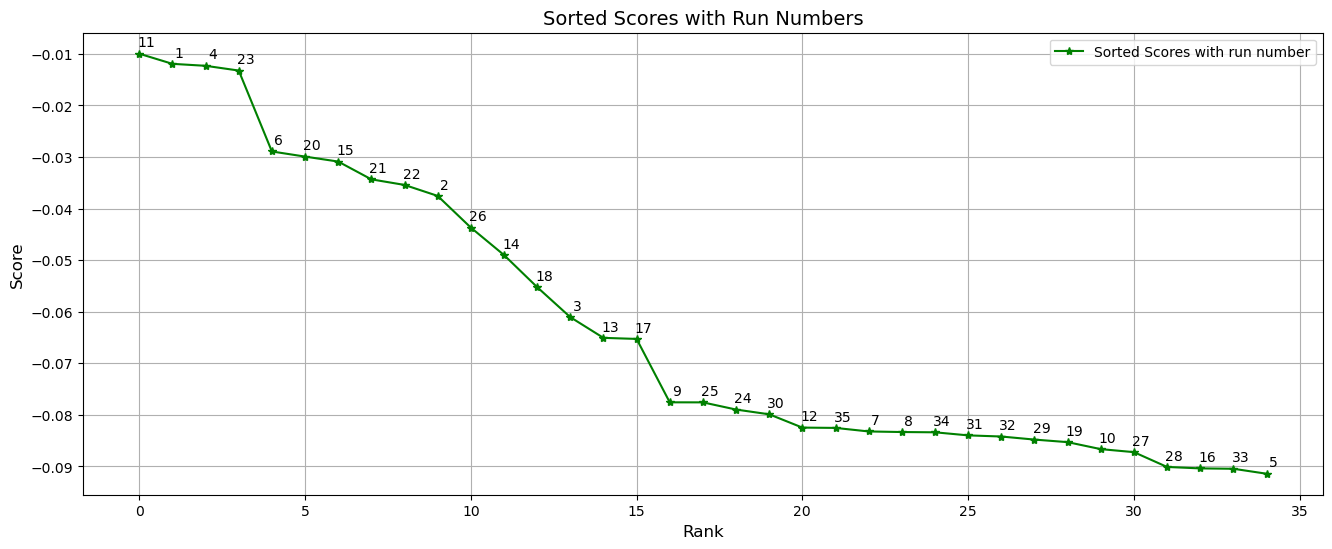

In [11]:
# Assuming optimizer.X and optimizer.Y are already defined
opt_res_param = optimizer.X
print(len(opt_res_param))
opt_res_score = optimizer.Y
opt_res_score = opt_res_score.flatten()

# Sort scores and retain original indices
original_indices = np.argsort(opt_res_score)[::-1]  # Indices for descending order
opt_res_score_sorted = opt_res_score[original_indices]
idx_opt_value = original_indices[len(original_indices)-1]


# Create N array (1 to len(opt_res_score_sorted))
N = np.arange(0, len(opt_res_score_sorted) )

# Set up the figure size
plt.figure(figsize=(16, 6))  # Width: 10 inches, Height: 6 inches

# Plot scores
plt.plot(N, opt_res_score_sorted, 'g*-', label="Sorted Scores with run number")  # Add a label for the legend
plt.grid()

# Annotate with original run numbers
for i, idx in enumerate(original_indices):
    plt.annotate(f"{idx+1}", (N[i], opt_res_score_sorted[i]), textcoords="offset points", xytext=(5, 5), ha='center')

# Add labels, title, and legend
plt.xlabel("Rank", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Sorted Scores with Run Numbers", fontsize=14)
plt.legend(loc="upper right", fontsize=10)  # Add a legend at the top right

# Show the plot
plt.show()

The best model is selected and its characteristics printed.

In [15]:
from tensorflow.keras.models import load_model
import os
import re

# 
folder_path = "checkpoints/"
opt_models = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
opt_models_sorted = sorted(opt_models , key=os.path.getctime, reverse=True)
opt_idx_model = original_indices[len(opt_models_sorted) - len(original_indices)-1]
best_fitting_model_file = opt_models_sorted[len(original_indices)-idx_opt_value-1]
#
model = load_model(best_fitting_model_file)
print(' best fitting model: ')
print(best_fitting_model_file)
# Inspect the model
model.summary()


# read learning rate (lr), regulator 2 and batch size

# Regular expressions for lr, l2, and batch
lr_match = re.search(r"lr_([0-9.]+)", best_fitting_model_file)
l2_match = re.search(r"l2_([0-9.]+)", best_fitting_model_file)
batch_match = re.search(r"batch_([0-9]+)", best_fitting_model_file)

# Extract values
lr = float(lr_match.group(1)) if lr_match else None
l2 = float(l2_match.group(1)) if l2_match else None
batch = int(batch_match.group(1)) if batch_match else None

# Print the results
print(f"Learning Rate (lr): {lr}")
print(f"L2 Regularization (l2): {l2}")
print(f"Batch Size (batch): {batch}")


 best fitting model: 
checkpoints/checkpoint_lr_1e-05_units_layer01_64_units_layer02_32_l2_0.01_batch_64.keras


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_31 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,952 (617.00 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,302 (411.34 KB)

Learning Rate (lr): 1.0
L2 Regularization (l2): 0.01
Batch Size (batch): 64


**Random Search**
Instead of trying all combinations (as in Grid Search), randomly sample from the hyperparameter space. This is computationally efficient and effective for larger spaces as mentioned earlier.

In [ ]:
import random
# Define the hyperparameter space
rs_bounds = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'units_layer01': [32, 64, 128, 256],
    'units_layer02': [32, 64, 128, 256],
    'l2_reg': [1e-6, 1e-2], 
    'batch_size': [16, 32, 64, 128]
}


# Random search
n_trials = 20
results = []

for i in range(n_trials):
    # Randomly sample hyperparameters
    params = {key: random.choice(values) for key, values in rs_bounds.items()}
    print(f"Trial {i+1}: {params}")

    # Create model with sampled parameters
    model = build_model(**params)
    
    # Train the model
    history = model.fit(x_train, y_train, epochs=5, batch_size=params['batch_size'], verbose=0, validation_split=0.2)
    
    # Evaluate the model
    loss, mse = model.evaluate(x_val y_val, verbose=0)
    results.append({'params': params, 'mse': mse})

# Find the best result
best_result = max(results, key=lambda x: x['mse'])
print(f"Best hyperparameters: {best_result['params']}")
print(f"Best accuracy: {best_result['accuracy']}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3999773986.py, line 27)

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html\
https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py\
https://www.linkedin.com/pulse/optimizing-machine-learning-models-bayesian-deep-dive-davis-joseph-qsqje?utm_source=share&utm_medium=member_android&utm_campaign=share_via